# Chapter3. 使用scikit-learn实现机器学习分类算法

## 1. 分类算法的选择
训练机器学习算法的步骤：
    1. 特征选择
    2. 确定性能评价标准
    3. 选择分类器及其优化算法
    4. 对模型性能的评估调优
    5. 算法的调优

## 2. 使用scikit-learn训练感知器

In [27]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
# 选择鸢尾花数据的第3和4列特征
X = iris.data[:, [2, 3]]
y = iris.target
# 输出标签种类
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


将数据集分为训练集(70%)和测试集(30%)

In [37]:
# 书中的train_test_split模块所属发生了更改
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

标准化特征值

In [38]:
from sklearn.preprocessing import StandardScaler

# 使用默认参数初始化
sc = StandardScaler()
# 使用fit方法计算训练数据中每个特征的均值和标准差
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

 在调用完fit方法计算出均值和标准差后，再使用transform方法使用上面计算出的均值和标准差对训练数据和测试数据做标准化处理。<br>
 这里要注意使用相同的样本均值和标准差来处理测试数据和训练数据，保证他们同倍缩放。在处理完数据后就可以训练感知器模型了。

In [40]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
      fit_intercept=True, max_iter=None, n_iter=40, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

从上面可以看出sklearn.linear_model.Perceptron的选项。其中random_state用于在每次迭代后初始化重排数据训练数据集

In [41]:
y_test.shape   # 测试集的数量

(45,)

In [45]:
# 使用predict方法进行预测
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 9


在对45朵花的分类中错了9个，错误率为9/45=0.20，准确率为1 - 1/5 = 0.80<br><br>
在metrics模块中，sklearn还实现了不同的性能矩阵，可以直观的看出分类器性能。

In [48]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.80


下面绘制数据集和决策边界

In [92]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker=markers[idx], label=cl)

    # 高亮显示测试数据
    if test_idx:
        # 使用versiontuple判断numpy的版本，如果版本低于1.9.0那么抛出warning
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        # 这里不能讲颜色选项设置为空，不然会显示不出来，所以挑了个颜色
        # alpha表示标记点的颜色强度，越小颜色越轻
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    color='cyan',
                    alpha=0.6,
                    linewidths=1,
                    marker='v',
                    s=55, label='test set')

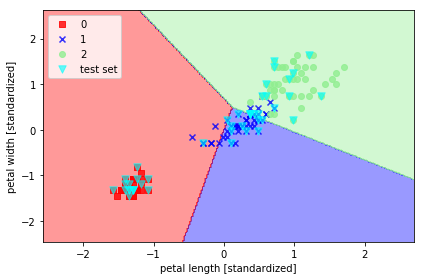

In [93]:
# 把测试集和训练集组合在一起
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

从结果可以看出，无法通过一个线性的感知器来完美区分三类样本。

## 2. 逻辑回归中的类别概率
### a. Sigmoid曲线

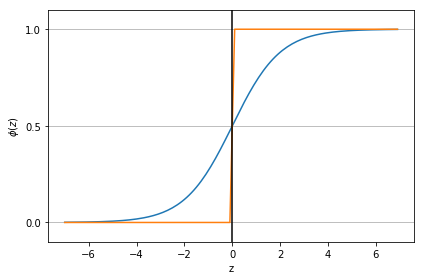

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
phi_z0 = sigmoid(100 * z)

plt.plot(z, phi_z)
plt.plot(z, phi_z0)
plt.axvline(0.0, color='k')
# 设置y坐标的范围，头尾多画一点
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# 设置y轴显示的坐标值
plt.yticks([0.0, 0.5, 1.0])
# gca方法获取当前坐标轴
ax = plt.gca()
# 获取坐标轴后，在y轴上显示网格
ax.yaxis.grid(True)

# tight_layout方法会自动调整子图参数，使之填充整个图像区域
plt.tight_layout()
plt.show()

可以看到，当$z$趋于无穷大时，$\phi(z)$趋于1，反之趋于0，另外，当z前面有系数的时候，系数越大，函数曲线越陡峭。

### b. 通过代价函数获得权重
$$ J(\phi(z), y; w)= \begin{cases} -log(\phi(z))  & \text {if $y=1$} \\ -log(1-\phi(z))  & \text{if $y=0$} \end{cases} $$

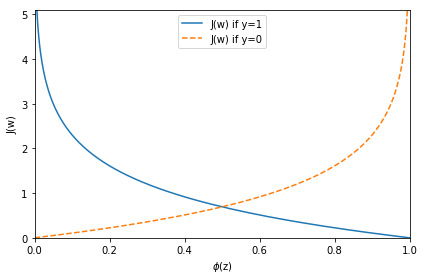

In [102]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

$z$ 不断变大时，根据sigmoid函数，会将类别判定为1，这时代价函数 $J$ 中的 $y=1$ ， $J$ 随着 $z$ 的增长减小，但是如果判断错误，也就是 $y=0$，那么代价函数就会增大，那么最小化代价函数就会把结果往正确的方向修正。

### c. 使用sklearn训练逻辑回归模型

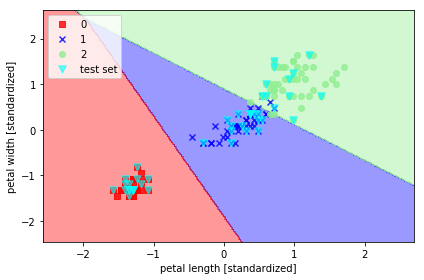

In [111]:
from sklearn.linear_model import LogisticRegression

# C为正则化项
# 书中没有solver和multi_class选项，抛出了FutureWarning警告
lr = LogisticRegression(C=1000.0, solver='liblinear', multi_class='auto', random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

可以看出逻辑回归也是一个线性模型。

In [146]:
# 预测第一个样本的概率
# 现在的predict_proba只识别2-D数据，
# lr.predict_proba(X_test_std[0,:])
lr.predict_proba(X_test_std[0,:].reshape(1, -1))

array([[1.30778783e-14, 6.10509954e-02, 9.38949005e-01]])

下面是0.17版本的sklearn中抛出的警告，到了0.19版本就直接抛出错误，以后需要注意。<br>
DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.<br><br>

上面输出的数组第三个元素表明当前样本属于第3个类别的概率为93.9%，第2个类别的概率为6.1%，基本不可能属于第一类。

In [147]:
print(lr.coef_)

[[-9.38578828 -8.61593847]
 [ 2.58122168 -2.38229239]
 [ 9.82646048  6.50252622]]


这里解释一下coef_的维度问题。可以看到coef_是3 × 2的，coef_[i]分别代表着属于第i个类别的权重参数，这里有三个类别，所以会输出三个权重参数。当使用他们计算Sigmoid函数的输出时，会输出三个概率，分别是属于这三个类别的概率值。

### d. 使用正则化解决过拟合问题

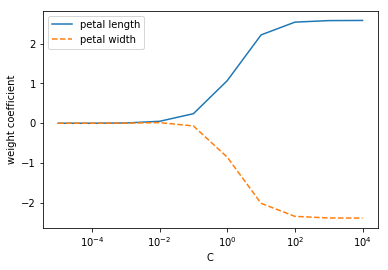

In [148]:
weights, params = [], []
for c in np.arange(-5, 5):
    # 生成一个从-5到5的正则化项列表，共10个，带入到模型中进行计算
    # 注意，C是逆正则化项，也就是乘在原代价函数位置的，不是权重向量，C=1/lambda
    # 这里和书中不同，不允许用整数进行负平方，也就是10 ** c是不允许的。把10改为浮点数即可
    lr = LogisticRegression(C=10.0 ** c, solver='liblinear', multi_class='auto', random_state=0)
    lr.fit(X_train_std, y_train)
    # weights保存了这些具有不同正则化项模型的权重系数
    # 使用第二个类别的权重参数绘制图像
    weights.append(lr.coef_[1])
    params.append(10.0 ** c)
    
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
# 设置x轴坐标的单位为log(x)
plt.xscale('log')
plt.show()

可以看到，当C增大时，$\lambda$减小，正则化的影响变小，模型方差增大。当C减小时，$\lambda$增大，正则化影响变大，系数开始缩减，直至接近0.<br><br>
为什么正则化项会影响系数呢。从正则化后的代价函数可以看出，当正则参数变小，也就是$\lambda$变大，在最小化代价函数的过程中，就会努力将系数变小。例如L2正则，那么在最小化代价函数时，如果使用梯度下降的方法，参数的梯度为$\lambda{w}$，$\lambda$较大，那么$w$缩减的速度就越快。同时，如果对代价函数求偏导，并令它等于0，可以得到$\lambda$的表达式：
$$\lambda = \frac*{w}$$
可以看出，为了最小化*，同时$\lambda$也要变大，那么${w}$会趋于0。

## 3. 使用支持向量机最大化分类间隔